In [2]:
import numpy as np
import warnings
import pandas as pd
from calibrators import * 
import pickle
warnings.filterwarnings("ignore")
import torch
import sys
from utils import *
sys.path.append('../')
import time
import copy
from SLURM.sklearn_config import *

# calculating ECEs on everything

In [3]:
Series = []
datasets = ['MNIST','Fashion','SignLanguage','CIFAR_RGB','GTSRB_RGB']
models = ['RF','GB','pytorch']
for dataset_name in datasets:
    for model_name in models:
        ECEs = []
        for shuffle in range(10):
            print(f'calculating {dataset_name}-{model_name}-{shuffle} ece....')
            ece = {}
            PATH_model= f'./stab/{dataset_name}/stab_2pool_{dataset_name}_{model_name}_{shuffle}.npy'
            
            # if not os.path.exists(PATH_model):
            #     continue
            #load model
            
            #model_info= load_model(dataset_name, model_name, shuffle)
            model_info= load_shuffle(dataset_name, model_name, shuffle)
            data=copy.copy(model_info.data)
            if model_name!='pytorch':
                model_dir =  f'{dataset_name}/{shuffle}/model/model_{dataset_name}_{model_name}.sav'
                model = pickle.load(open(model_dir, 'rb'))
            
            # compute ece's
            #Base
            idCal = IdentityCalibrator()
            idCal.fit(model_info.all_predictions_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Base'] = idCal.ECE(model_info.all_predictions_test, model_info.y_pred_test, model_info.data.y_test)
            if model_name=='pytorch':
                ece['SKlearn_calibrator_isotonic']=100
                ece['SKlearn_calibrator_platt']=100
            else:
                #Isotonic_sklearn
                ece['SKlearn_calibrator_isotonic'] = SKlearn_calibrator(data,'isotonic',model).fit().ECE()

            # #iso_self_imp
            # isoCal = IsotonicCalibrator()
            # isoCal.fit(model_info.all_predictions_val ,model_info.y_pred_val==model_info.data.y_val)
            # ece['IsotonicCalibrator'] = isoCal.ECE(model_info.all_predictions_test, model_info.y_pred_test, model_info.data.y_test)

                #sklearn platt
                ece['SKlearn_calibrator_platt'] = SKlearn_calibrator(data,'sigmoid',model).fit().ECE()

#             #plat_self_imp
#             platCal = PlattCalibrator()
#             platCal.fit(model_info.all_predictions_val ,model_info.y_pred_val==model_info.data.y_val)
#             ece['PlattCalibrator'] = platCal.ECE(model_info.all_predictions_test, model_info.y_pred_test, model_info.data.y_test)
 
#             #stab
            stabCal = StabilityCalibrator()
            stabCal.fit(model_info.stability_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['StabilityCalibrator'] = stabCal.ECE(model_info.stability_test, model_info.y_pred_test, model_info.data.y_test)

            # #Sep
            # sepCal = SeparationCalibrator()
            # sepCal.fit(model_info.sep_val ,model_info.y_pred_val==model_info.data.y_val)
            # ece['SeparationCalibrator'] = sepCal.ECE(model_info.sep_test, model_info.y_pred_test, model_info.data.y_test)
            
            new_stab_dir= f'./stab/{dataset_name}/'
        
            #stab avg2
            stab2avg_val=np.load(new_stab_dir+f'stab_2pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab2avg_test=np.load(new_stab_dir+f'test_stab_2pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab2avgCal = StabilityCalibrator()
            stab2avgCal.fit(stab2avg_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Stab2avg'] = stab2avgCal.ECE(stab2avg_test, model_info.y_pred_test, model_info.data.y_test)

            
            #stab avg3
            stab3avg_val=np.load(new_stab_dir+f'stab_3pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab3avg_test=np.load(new_stab_dir+f'test_stab_3pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab3avgCal = StabilityCalibrator()
            stab3avgCal.fit(stab3avg_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Stab3avg'] = stab3avgCal.ECE(stab3avg_test, model_info.y_pred_test, model_info.data.y_test)

            
            #stab avg4
            stab4avg_val=np.load(new_stab_dir+f'stab_4pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab4avg_test=np.load(new_stab_dir+f'test_stab_4pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab4avgCal = StabilityCalibrator()
            stab4avgCal.fit(stab4avg_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Stab4avg'] = stab4avgCal.ECE(stab4avg_test, model_info.y_pred_test, model_info.data.y_test)
            
            
            #stab max2
            stab2max_val=np.load(new_stab_dir+f'stab_2maxpool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab2max_test=np.load(new_stab_dir+f'test_stab_2maxpool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab2maxCal = StabilityCalibrator()
            stab2maxCal.fit(stab2max_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Stab2max'] = stab2maxCal.ECE(stab2max_test, model_info.y_pred_test, model_info.data.y_test)
            
            #stab max3
            stab3max_val=np.load(new_stab_dir+f'stab_3maxpool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab3max_test=np.load(new_stab_dir+f'test_stab_3maxpool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab3maxCal = StabilityCalibrator()
            stab3maxCal.fit(stab3max_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Stab3max'] = stab3maxCal.ECE(stab3max_test, model_info.y_pred_test, model_info.data.y_test)
            

            #stab max4
            stab4max_val=np.load(new_stab_dir+f'stab_4maxpool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab4max_test=np.load(new_stab_dir+f'test_stab_4maxpool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab4maxCal = StabilityCalibrator()
            stab4maxCal.fit(stab4max_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Stab4max'] = stab4maxCal.ECE(stab4max_test, model_info.y_pred_test, model_info.data.y_test)
            


            # HB_toplabel
            HBcali = HBCalibrator()
            HBcali.fit(model_info.all_predictions_val, model_info.data.y_val + 1)
            prob_HB = HBcali.calibrate(model_info.all_predictions_test)
            ece['HBCalibrator'] = ECE_calc(prob_HB, model_info.y_pred_test, model_info.data.y_test, bins=15)

            #SBC
            SBCcali = SBCCalibrator()
            SBCcali.fit(model_info.all_predictions_val, model_info.data.y_val)
            SBC_probs_test = SBCcali.calibrate(model_info.all_predictions_test)
            y_SBC_test = np.argmax(SBC_probs_test,axis=1)
            ece['SBCCalibrator'] = ECE_calc(SBC_probs_test, y_SBC_test, model_info.data.y_test, bins=15)

            PATH = f'./{dataset_name}/{shuffle}/{model_name}/ece.npy'
            # np.save(PATH,ece)
            
            print(ece)
            ECEs.append(ece)
            
    
        values = np.array([list(dic.values()) for dic in ECEs]) 
        conf_interval = np.apply_along_axis(mean_confidence_interval_str, 0, values)
        calib_methods = list(ece.keys())
        prep_df_mnist = {calib:val for val, calib in zip(conf_interval, calib_methods)}
        series = pd.DataFrame.from_dict(prep_df_mnist, orient = 'index', columns=[f'{dataset_name}-{model_name}'])
        Series.append(series.T)

calculating MNIST-RF-0 ece....
{'Base': 0.1658024551817865, 'SKlearn_calibrator_isotonic': 0.007236461293702406, 'SKlearn_calibrator_platt': 0.013389381446227292, 'StabilityCalibrator': 0.003758624189585668, 'Stab2avg': 0.004687860467464543, 'Stab3avg': 0.0034928307962898194, 'Stab4avg': 0.0042824515882548455, 'Stab2max': 0.0036200852331773887, 'Stab3max': 0.004857055470016411, 'Stab4max': 0.005279742034634669, 'HBCalibrator': 0.004941807756706013, 'SBCCalibrator': 0.03498153236265749}
calculating MNIST-RF-1 ece....
{'Base': 0.16442418381157936, 'SKlearn_calibrator_isotonic': 0.011492964004565493, 'SKlearn_calibrator_platt': 0.016081972797704503, 'StabilityCalibrator': 0.002954364561857901, 'Stab2avg': 0.004435136076640629, 'Stab3avg': 0.003193509285847623, 'Stab4avg': 0.004454159247263431, 'Stab2max': 0.0031729688470836337, 'Stab3max': 0.002709780803666313, 'Stab4max': 0.0023510141320791746, 'HBCalibrator': 0.005810122863666688, 'SBCCalibrator': 0.04216912675503584}
calculating MNIST-

In [4]:
df_comparison = pd.concat(Series)[['Stab2avg','Stab3avg','Stab4avg','Stab2max','Stab3max','Stab4max','StabilityCalibrator', 'Base', 'SKlearn_calibrator_isotonic', 'SKlearn_calibrator_platt', 'HBCalibrator', 'SBCCalibrator']]
df_comparison.style.apply(color_max, axis=1)

,Stab2avg,Stab3avg,Stab4avg,Stab2max,Stab3max,Stab4max,StabilityCalibrator,Base,SKlearn_calibrator_isotonic,SKlearn_calibrator_platt,HBCalibrator,SBCCalibrator
MNIST-RF,0.0040+-0.0008,0.0036+-0.0007,0.0047+-0.0007,0.0032+-0.0005,0.0042+-0.0006,0.0038+-0.0008,0.0039+-0.0006,0.1629+-0.0016,0.0090+-0.0012,0.0148+-0.0007,0.0053+-0.0004,0.0366+-0.0038
MNIST-GB,0.0038+-0.0010,0.0035+-0.0007,0.0036+-0.0009,0.0030+-0.0007,0.0034+-0.0010,0.0032+-0.0009,0.0036+-0.0007,0.0170+-0.0010,0.0174+-0.0015,0.0194+-0.0013,0.0048+-0.0008,0.0823+-0.0024
MNIST-pytorch,0.0019+-0.0004,0.0022+-0.0006,0.0018+-0.0004,0.0018+-0.0004,0.0020+-0.0004,0.0016+-0.0005,0.0016+-0.0006,0.0065+-0.0006,100.0000+-0.00,100.0000+-0.00,0.0027+-0.0010,0.0870+-0.0052
Fashion-RF,0.0081+-0.0016,0.0078+-0.0010,0.0082+-0.0014,0.0087+-0.0014,0.0083+-0.0016,0.0072+-0.0013,0.0074+-0.0016,0.0918+-0.0014,0.0091+-0.0011,0.0374+-0.0012,0.0107+-0.0015,0.0345+-0.0031
Fashion-GB,0.0078+-0.0009,0.0077+-0.0020,0.0078+-0.0014,0.0077+-0.0015,0.0081+-0.0013,0.0074+-0.0017,0.0073+-0.0013,0.0245+-0.0023,0.0380+-0.0020,0.0571+-0.0391,0.0106+-0.0014,0.0390+-0.0046
Fashion-pytorch,0.0063+-0.0012,0.0070+-0.0012,0.0071+-0.0009,0.0061+-0.0008,0.0066+-0.0007,0.0069+-0.0010,0.0080+-0.0015,0.0786+-0.0027,100.0000+-0.00,100.0000+-0.00,0.0100+-0.0018,0.0724+-0.0046
SignLanguage-RF,0.0012+-0.0002,0.0015+-0.0004,0.0019+-0.0003,0.0012+-0.0003,0.0017+-0.0005,0.0014+-0.0004,0.0008+-0.0002,0.2536+-0.0015,0.0039+-0.0006,0.0174+-0.0008,0.0019+-0.0006,0.1688+-0.0066
SignLanguage-GB,0.0012+-0.0002,0.0018+-0.0004,0.0024+-0.0003,0.0014+-0.0003,0.0024+-0.0003,0.0027+-0.0004,0.0008+-0.0003,0.0059+-0.0010,0.0405+-0.0018,0.0596+-0.0017,0.0047+-0.0004,0.3097+-0.0017
SignLanguage-pytorch,0.0003+-0.0001,0.0004+-0.0001,0.0006+-0.0002,0.0003+-0.0001,0.0005+-0.0002,0.0006+-0.0001,0.0004+-0.0003,0.0025+-0.0008,100.0000+-0.00,100.0000+-0.00,0.0009+-0.0007,0.1755+-0.0094
CIFAR_RGB-RF,0.0135+-0.0034,0.0097+-0.0019,0.0117+-0.0025,0.0127+-0.0019,0.0127+-0.0033,0.0121+-0.0021,0.0115+-0.0024,0.1729+-0.0029,0.0325+-0.0028,0.0459+-0.0024,0.0252+-0.0041,0.0299+-0.0026


In [6]:
df_comparison.to_csv("all_eces.csv")

In [6]:
df_comparison=pd.read_csv("all_eces.csv")
df_comparison.drop(columns=['Stab2max'])

,Unnamed: 0,Stab2avg,Stab3avg,Stab4avg,StabilityCalibrator,Base,SKlearn_calibrator_isotonic,SKlearn_calibrator_platt,HBCalibrator,SBCCalibrator
0,MNIST-RF,0.0040+-0.0008,0.0036+-0.0007,0.0047+-0.0007,0.0039+-0.0006,0.1629+-0.0016,0.0090+-0.0012,0.0148+-0.0007,0.0053+-0.0004,0.0366+-0.0038
1,MNIST-GB,0.0038+-0.0010,0.0035+-0.0007,0.0036+-0.0009,0.0036+-0.0007,0.0170+-0.0010,0.0174+-0.0015,0.0194+-0.0013,0.0048+-0.0008,0.0823+-0.0024
2,MNIST-pytorch,0.0019+-0.0004,0.0022+-0.0006,0.0018+-0.0004,0.0016+-0.0006,0.0065+-0.0006,100.0000+-0.00,100.0000+-0.00,0.0027+-0.0010,0.0870+-0.0052
3,Fashion-RF,0.0081+-0.0016,0.0078+-0.0010,0.0082+-0.0014,0.0074+-0.0016,0.0918+-0.0014,0.0091+-0.0011,0.0374+-0.0012,0.0108+-0.0014,0.0345+-0.0031
4,Fashion-GB,0.0078+-0.0009,0.0077+-0.0020,0.0078+-0.0014,0.0073+-0.0013,0.0245+-0.0023,0.0380+-0.0020,0.0571+-0.0391,0.0106+-0.0014,0.0390+-0.0046
5,Fashion-pytorch,0.0063+-0.0012,0.0070+-0.0012,0.0071+-0.0009,0.0080+-0.0015,0.0786+-0.0027,100.0000+-0.00,100.0000+-0.00,0.0102+-0.0015,0.0724+-0.0046
6,SignLanguage-RF,0.0012+-0.0002,0.0015+-0.0004,0.0019+-0.0003,0.0008+-0.0002,0.2536+-0.0015,0.0039+-0.0006,0.0174+-0.0008,0.0019+-0.0006,0.1688+-0.0066
7,SignLanguage-GB,0.0012+-0.0002,0.0018+-0.0004,0.0024+-0.0003,0.0008+-0.0003,0.0059+-0.0010,0.0405+-0.0018,0.0596+-0.0017,0.0047+-0.0004,0.3097+-0.0017
8,SignLanguage-pytorch,0.0003+-0.0001,0.0004+-0.0001,0.0006+-0.0002,0.0004+-0.0003,0.0025+-0.0008,100.0000+-0.00,100.0000+-0.00,0.0009+-0.0007,0.1755+-0.0094
9,CIFAR_RGB-RF,0.0135+-0.0034,0.0097+-0.0019,0.0117+-0.0025,0.0115+-0.0024,0.1729+-0.0029,0.0325+-0.0028,0.0459+-0.0024,0.0254+-0.0040,0.0299+-0.0026


In [10]:
df_comparison[['Stab2avg','Stab3avg','Stab4avg','StabilityCalibrator', 'Base', 'SKlearn_calibrator_isotonic', 'SKlearn_calibrator_platt', 'HBCalibrator', 'SBCCalibrator']].style.apply(color_max, axis=1)

,Stab2avg,Stab3avg,Stab4avg,StabilityCalibrator,Base,SKlearn_calibrator_isotonic,SKlearn_calibrator_platt,HBCalibrator,SBCCalibrator
0,0.0040+-0.0008,0.0036+-0.0007,0.0047+-0.0007,0.0039+-0.0006,0.1629+-0.0016,0.0090+-0.0012,0.0148+-0.0007,0.0053+-0.0004,0.0366+-0.0038
1,0.0038+-0.0010,0.0035+-0.0007,0.0036+-0.0009,0.0036+-0.0007,0.0170+-0.0010,0.0174+-0.0015,0.0194+-0.0013,0.0048+-0.0008,0.0823+-0.0024
2,0.0019+-0.0004,0.0022+-0.0006,0.0018+-0.0004,0.0016+-0.0006,0.0065+-0.0006,100.0000+-0.00,100.0000+-0.00,0.0027+-0.0010,0.0870+-0.0052
3,0.0081+-0.0016,0.0078+-0.0010,0.0082+-0.0014,0.0074+-0.0016,0.0918+-0.0014,0.0091+-0.0011,0.0374+-0.0012,0.0108+-0.0014,0.0345+-0.0031
4,0.0078+-0.0009,0.0077+-0.0020,0.0078+-0.0014,0.0073+-0.0013,0.0245+-0.0023,0.0380+-0.0020,0.0571+-0.0391,0.0106+-0.0014,0.0390+-0.0046
5,0.0063+-0.0012,0.0070+-0.0012,0.0071+-0.0009,0.0080+-0.0015,0.0786+-0.0027,100.0000+-0.00,100.0000+-0.00,0.0102+-0.0015,0.0724+-0.0046
6,0.0012+-0.0002,0.0015+-0.0004,0.0019+-0.0003,0.0008+-0.0002,0.2536+-0.0015,0.0039+-0.0006,0.0174+-0.0008,0.0019+-0.0006,0.1688+-0.0066
7,0.0012+-0.0002,0.0018+-0.0004,0.0024+-0.0003,0.0008+-0.0003,0.0059+-0.0010,0.0405+-0.0018,0.0596+-0.0017,0.0047+-0.0004,0.3097+-0.0017
8,0.0003+-0.0001,0.0004+-0.0001,0.0006+-0.0002,0.0004+-0.0003,0.0025+-0.0008,100.0000+-0.00,100.0000+-0.00,0.0009+-0.0007,0.1755+-0.0094
9,0.0135+-0.0034,0.0097+-0.0019,0.0117+-0.0025,0.0115+-0.0024,0.1729+-0.0029,0.0325+-0.0028,0.0459+-0.0024,0.0254+-0.0040,0.0299+-0.0026


# Distribution of the stabilities fro different pool sizes

pool=2


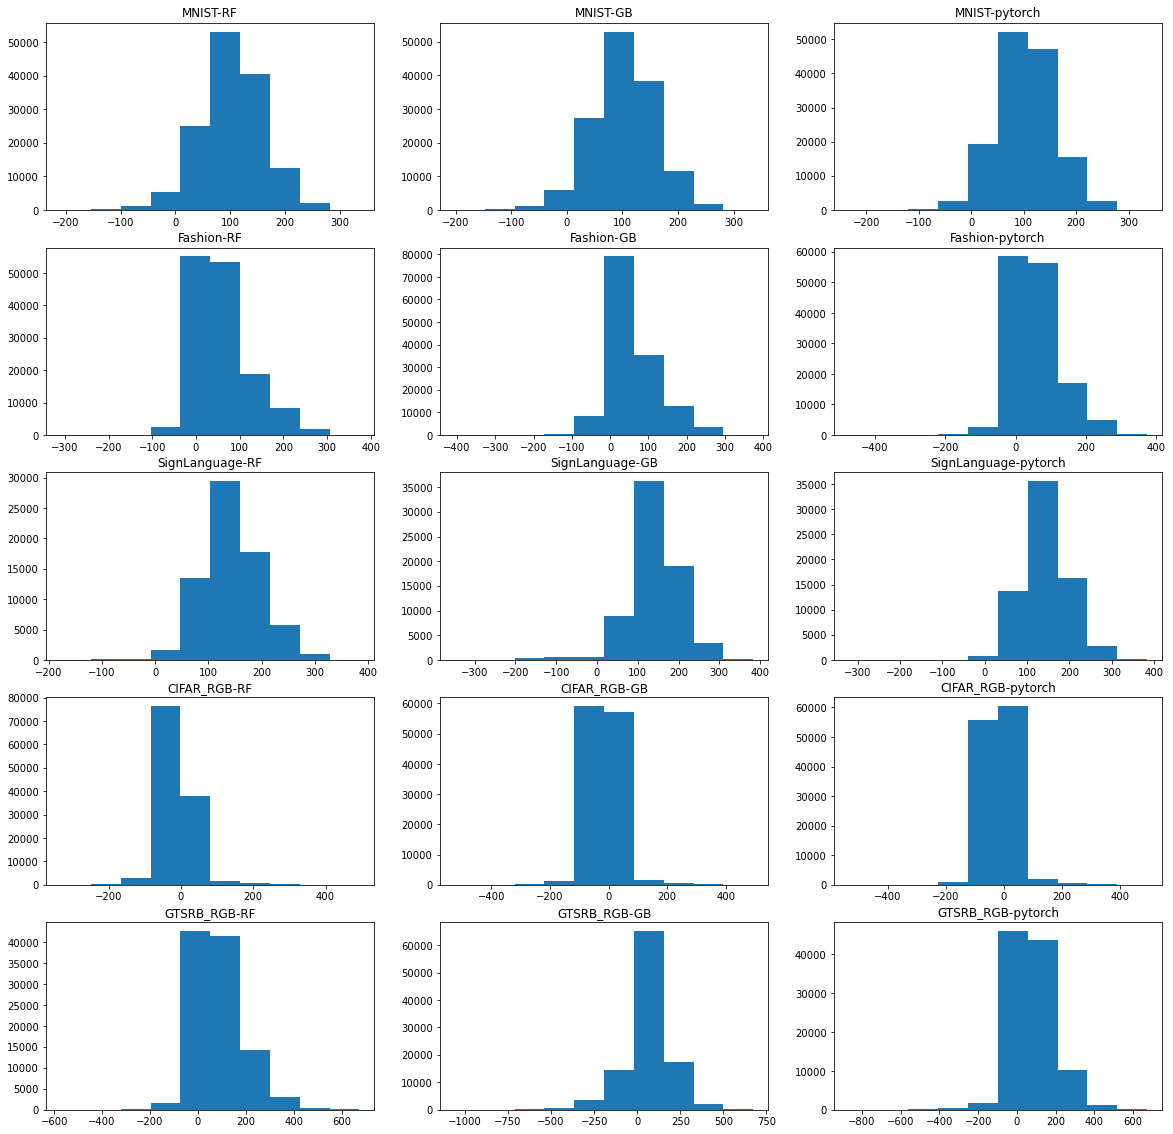

In [20]:
datasets = ['MNIST','Fashion','SignLanguage','CIFAR_RGB','GTSRB_RGB']
models = ['RF','GB','pytorch']
plt.figure(1,figsize=(20,20))

plt.title("pool=2")
i=1
for dataset_name in datasets:
    for model_name in models:
        stab=[]
        for shuffle in range(10):
            s=np.load(f'./stab/{dataset_name}/test_stab_2pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab.append(s)
        stab=np.array(stab).flatten()
        plt.subplot(5,3,i)
        plt.hist(stab)
        plt.title(f'{dataset_name}-{model_name}')
        i+=1

print("pool=2")
        

pool=3


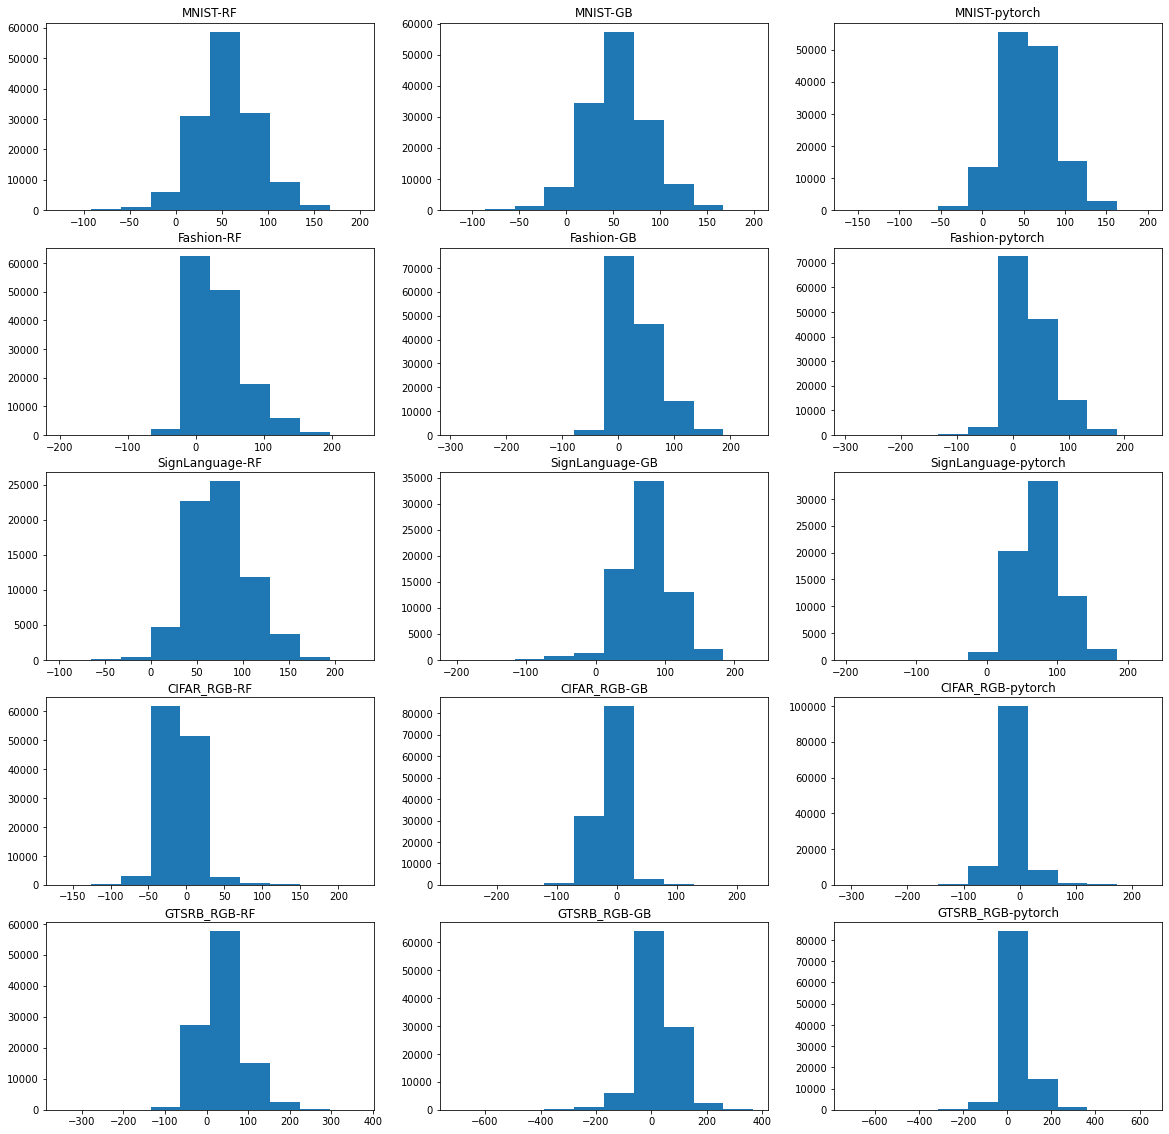

In [21]:
datasets = ['MNIST','Fashion','SignLanguage','CIFAR_RGB','GTSRB_RGB']
models = ['RF','GB','pytorch']
plt.figure(1,figsize=(20,20))

plt.title("pool=2")
i=1
for dataset_name in datasets:
    for model_name in models:
        stab=[]
        for shuffle in range(10):
            s=np.load(f'./stab/{dataset_name}/test_stab_3pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab.append(s)
        stab=np.array(stab).flatten()
        plt.subplot(5,3,i)
        plt.hist(stab)
        plt.title(f'{dataset_name}-{model_name}')
        i+=1

print("pool=3")

pool=4


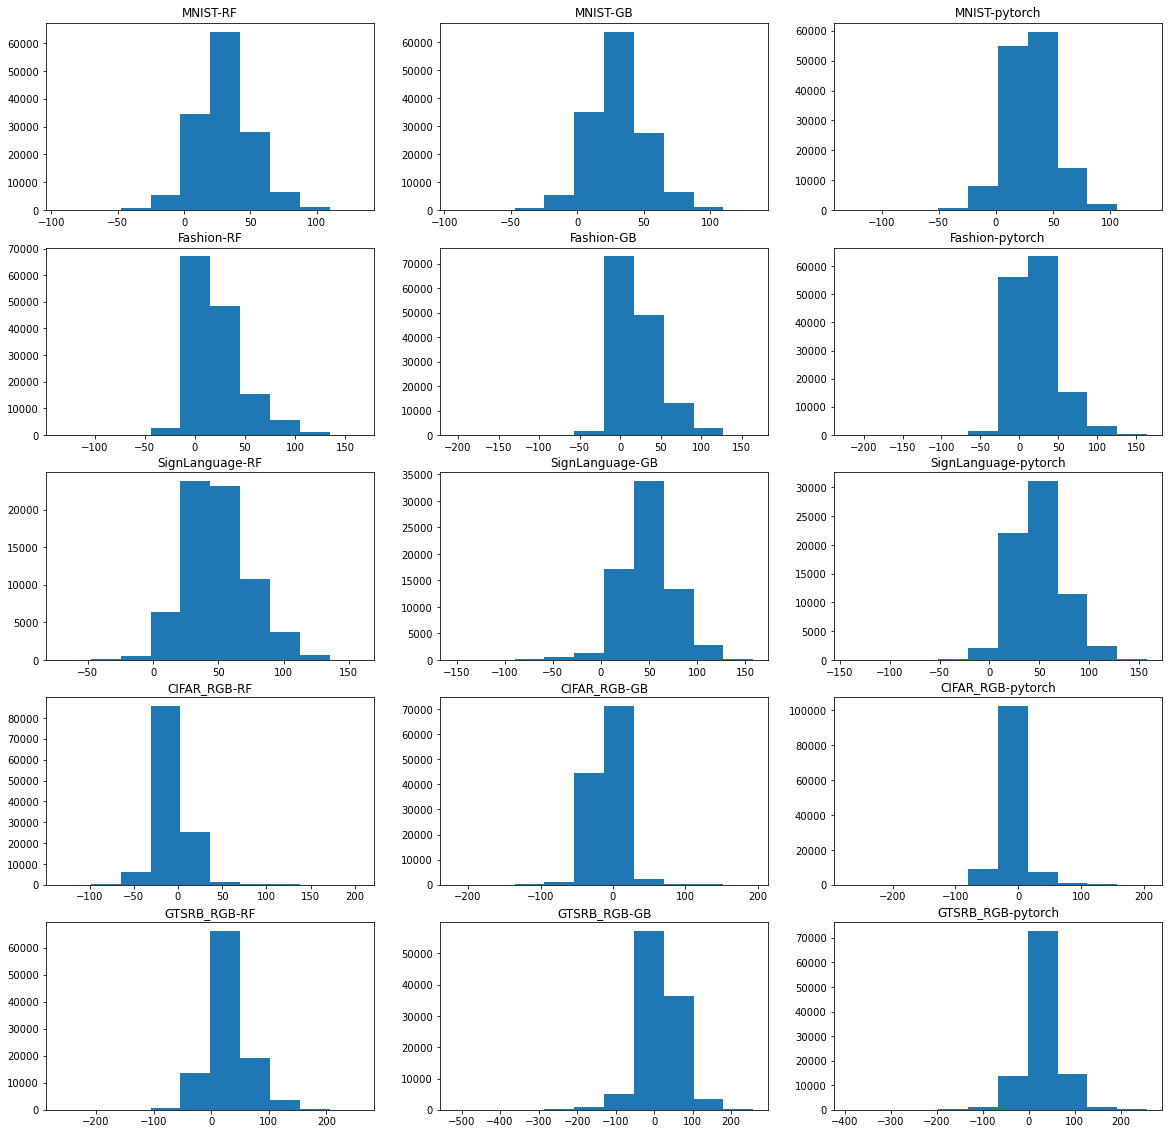

In [22]:
datasets = ['MNIST','Fashion','SignLanguage','CIFAR_RGB','GTSRB_RGB']
models = ['RF','GB','pytorch']
plt.figure(1,figsize=(20,20))

plt.title("pool=4")
i=1
for dataset_name in datasets:
    for model_name in models:
        stab=[]
        for shuffle in range(10):
            s=np.load(f'./stab/{dataset_name}/test_stab_4pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab.append(s)
        stab=np.array(stab).flatten()
        plt.subplot(5,3,i)
        plt.hist(stab)
        plt.title(f'{dataset_name}-{model_name}')
        i+=1

print("pool=4")

Distribution of the stabilities fro different pool sizes:


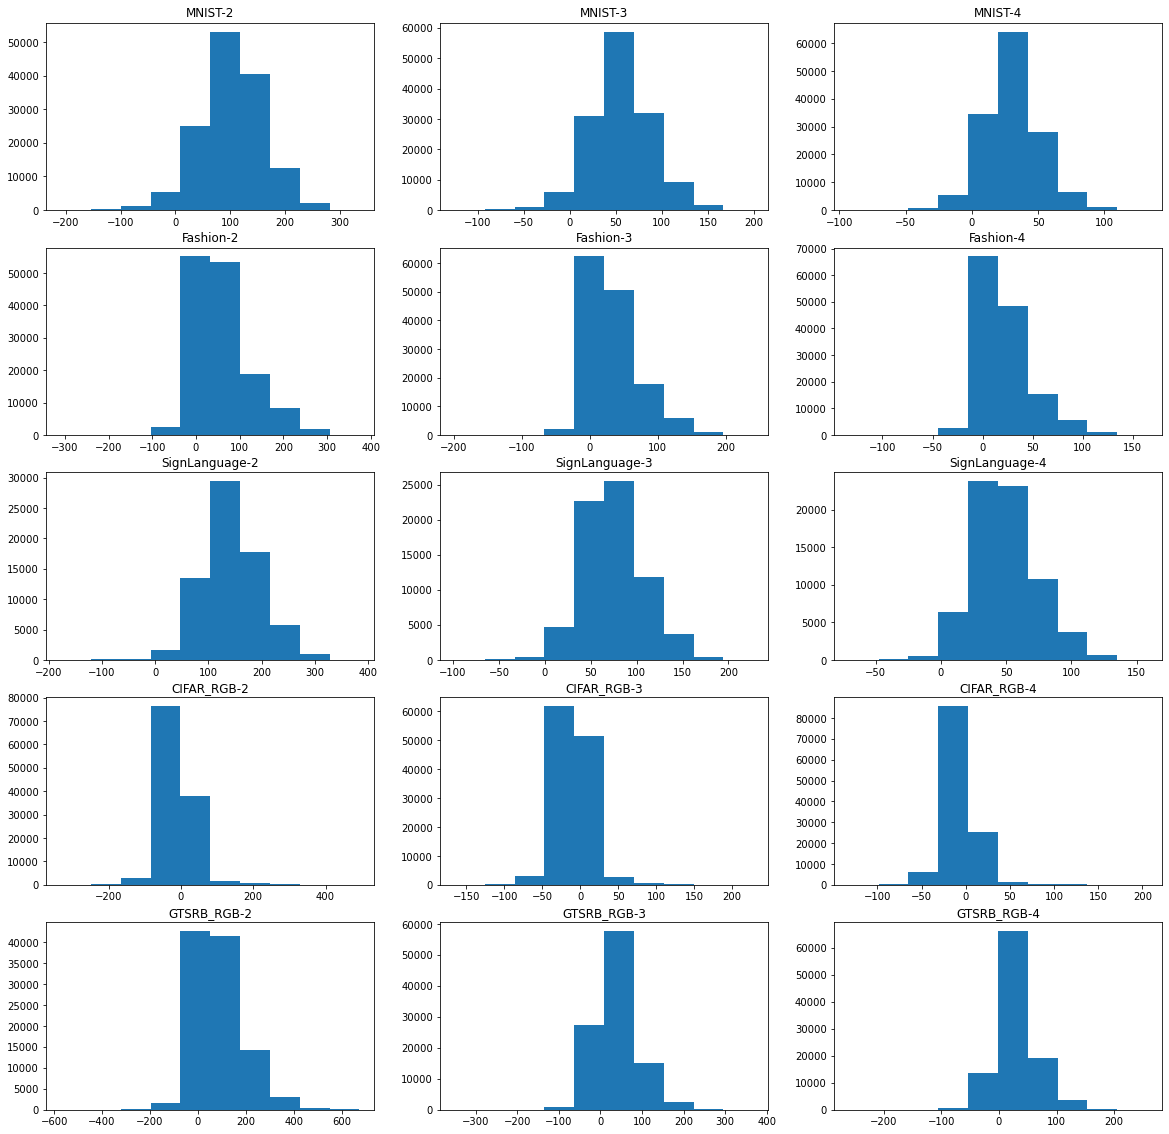

In [35]:
datasets = ['MNIST','Fashion','SignLanguage','CIFAR_RGB','GTSRB_RGB']
model_name = 'RF'
plt.figure(1,figsize=(20,20))

i=1
for dataset_name in datasets:
    for pool_size in range(2,5):
        stab=[]
        for shuffle in range(10):
            s=np.load(f'./stab/{dataset_name}/test_stab_{pool_size}pool_{dataset_name}_{model_name}_{shuffle}.npy')
            stab.append(s)
        stab=np.array(stab).flatten()
        plt.subplot(5,3,i)
        plt.hist(stab)
        plt.title(f'{dataset_name}-{pool_size}')
        i+=1

print("Distribution of the stabilities fro different pool sizes:")


In [34]:
df_time=pd.read_csv("all_time_df.csv")
df_time['MNIST']

0    {2: 82.4797901516526, 3: 187.5781990360848, 4:...
1    {2: 83.00860176278401, 3: 178.69949254099794, ...
2    {2: 81.92048388857252, 3: 178.13157531339985, ...
Name: MNIST, dtype: object

In [26]:
os.path.getsize('./MNIST/0/model/model_MNIST_GB.sav')*10^(-6)

138939357

In [31]:
os.path.getsize('./MNIST/0/model/model_MNIST_RF.sav')/10**6

117.582553